In [1]:
import os
import errno
import numpy as np 
import deepcell
from deepcell_toolbox.multiplex_utils import multiplex_preprocess

In [2]:
# create folder for this set of experiments
experiment_folder = "20201206_transfer_decidua"
MODEL_DIR = os.path.join("/data/analyses", experiment_folder)
NPZ_DIR = "/data/npz_data/"
LOG_DIR = '/data/logs'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [3]:
train_dict = np.load(NPZ_DIR + "Decidua_Shirley_Relabel_Blanked_256x256_stride_0.5.npz")

In [17]:
X_train = train_dict['X']
new_x = np.zeros((X_train.shape[0], 256, 256, 2))
new_x[..., 0] = X_train[..., 0]
new_x[..., 1] = np.sum(X_train[..., 1:], axis=-1)
np.savez_compressed(NPZ_DIR + 'Decidua_Shirley_Relabel_Blanked_256x256_stride_0.5_summed.npz', 
                    X=new_x, y=train_dict['y'])

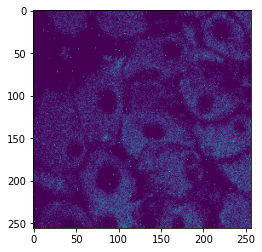

In [16]:
import matplotlib.pyplot as plt
plt.imshow(new_x[100, :, :, 1])

In [3]:
from deepcell.utils.data_utils import get_data
from skimage.segmentation import relabel_sequential

npz_name = "Decidua_Shirley_Relabel_Blanked_256x256_stride_0.5"

test_size=0.2
seed=0
DATA_FILE = NPZ_DIR + npz_name + ".npz"
train_dict, val_dict = get_data(DATA_FILE, test_size=test_size, seed=seed)
X_train, y_train = train_dict['X'], train_dict['y']
X_val, y_val = val_dict['X'], val_dict['y']
print(X_train.shape, X_val.shape)

(512, 256, 256, 6) (128, 256, 256, 6)


X.shape: (512, 256, 256, 6)
y.shape: (512, 256, 256, 1)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]


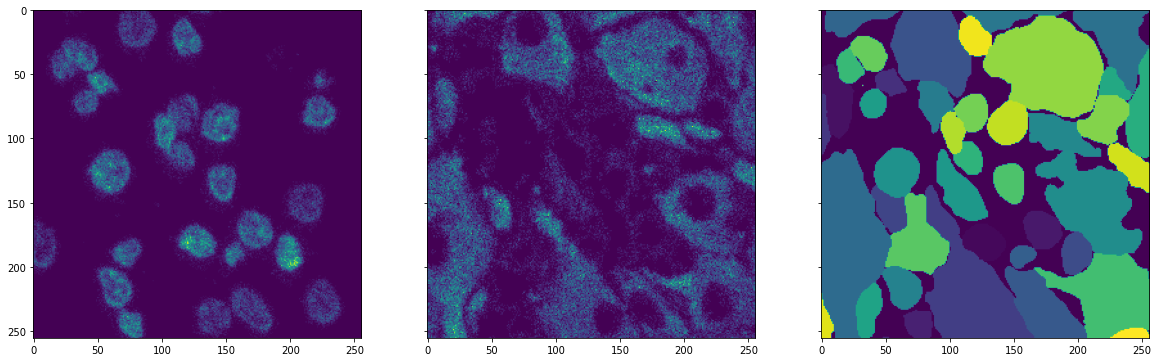

In [4]:
for i in range(y_train.shape[0]):
        y_train[i], _, _ = relabel_sequential(y_train[i])
        
for i in range(y_val.shape[0]):
        y_val[i], _, _ = relabel_sequential(y_val[i])
        
               
print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 20), sharex=True, sharey=True)

idx = 303
axes[0].imshow(X_train[idx,:,:,0])
axes[1].imshow(X_train[idx,:,:,1])
axes[2].imshow(y_train[idx,:,:,0])
print(np.unique(y_train[idx]))

In [5]:
X_train = multiplex_preprocess(X_train)
X_val = multiplex_preprocess(X_val)

In [6]:
from deepcell.model_zoo.panopticnet import PanopticNet

new_model = PanopticNet(
    backbone='resnet50',
    input_shape=(256, 256, 5),
    norm_method=None,
    num_semantic_heads=2,
    num_semantic_classes=[1,3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True,
    use_imagenet=False)

W1207 20:15:23.510150 140713805567808 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [24]:
#new_model.load_weights('/data/analyses/size_benchmarking/20201018_multiplex_seed_1__subset_2665.h5')

In [7]:
old_model = PanopticNet(
    backbone='resnet50',
    input_shape=(256, 256, 2),
    norm_method=None,
    num_semantic_heads=2,
    num_semantic_classes=[1, 3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True,
    use_imagenet=False)
old_model.load_weights('/data/analyses/size_benchmarking/20201018_multiplex_seed_1__subset_2665.h5')

In [8]:
for i, layer in enumerate(new_model.layers):
    if layer.get_weights() == []:
        pass
    if layer.name == 'conv_channels':
        pass
    else:
        old_weights = old_model.layers[i].get_weights()
        new_model.layers[i].set_weights(old_weights)

In [9]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = npz_name + '_deep_watershed'

n_epoch = 40  # Number of training epochs

optimizer = Adam(lr=1e-5, clipnorm=0.001)
lr_sched = rate_scheduler(lr=1e-5, decay=0.99)

batch_size = 8

min_objects = 3  # throw out images with fewer than this many objects
seed=0
model_name

'Decidua_Shirley_Relabel_Blanked_256x256_stride_0.5_deep_watershed'

In [10]:
from deepcell import image_generators
from deepcell.utils import train_utils


# use augmentation for training but not validation
datagen = image_generators.SemanticDataGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.7, 1/0.7),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.SemanticDataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0)
    
train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=['inner-distance', 'pixelwise'],
    transforms_kwargs={'pixelwise':{'dilation_radius': 1}, 
                      'inner-distance': {'erosion_width': 1, 'alpha': 'auto'}},
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_val, 'y': y_val},
    seed=seed,
    transforms=['inner-distance', 'pixelwise'],
    transforms_kwargs={'pixelwise':{'dilation_radius': 1},
                      'inner-distance': {'erosion_width': 1, 'alpha': 'auto'}},
    min_objects=min_objects,
    batch_size=batch_size)

W1207 20:21:20.826491 140713805567808 semantic.py:111] X data dtype is float32: this will increase memory use during preprocessing. Consider using a smaller dtype
W1207 20:21:34.218804 140713805567808 semantic.py:111] X data dtype is float32: this will increase memory use during preprocessing. Consider using a smaller dtype


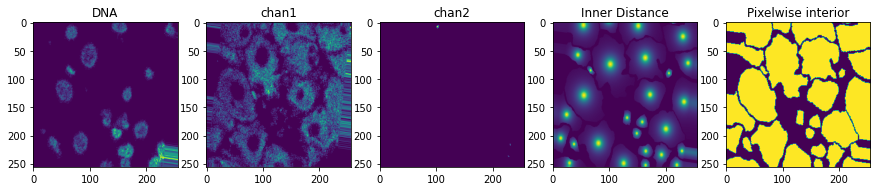

In [11]:
from matplotlib import pyplot as plt

inputs, outputs = train_data.next()

img = inputs[0]
inner_distance = outputs[0]
pixelwise = outputs[1]

fig, axes = plt.subplots(1, 5, figsize=(15, 15))

axes[0].imshow(img[:, :, 0])
axes[0].set_title('DNA')

axes[1].imshow(img[:, :, 1])
axes[1].set_title('chan1')

axes[2].imshow(img[:, :, 2])
axes[2].set_title('chan2')

axes[3].imshow(inner_distance[0, ..., 0])
axes[3].set_title('Inner Distance')

axes[4].imshow(pixelwise[0, ..., 1])
axes[4].set_title('Pixelwise interior')

plt.show()

In [12]:
# Create a dictionary of losses for each semantic head
from tensorflow.python.keras.losses import MSE
from deepcell import losses


def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * losses.weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss


loss = {}

# Give losses for all of the semantic heads
for layer in new_model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)

In [13]:
new_model.compile(loss=loss, optimizer=optimizer)

In [14]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus


model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    tensorboard_log_dir=LOG_DIR,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = new_model.fit_generator(
    train_data,
    #steps_per_epoch=train_data.y.shape[0] // batch_size,
    steps_per_epoch=300,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
Epoch 1/40


ValueError: Error when checking input: expected input_0 to have shape (256, 256, 5) but got array with shape (256, 256, 6)

In [86]:
new_model.load_weights(os.path.join(MODEL_DIR, model_name + '.h5'))

In [32]:
import xarray as xr
data_dir = '/data/shirley/cohort/20200611_cohort/'
input_data = xr.open_dataarray(data_dir + 'deepcell_input.xr')

In [37]:
reformatted = np.zeros((10, 2048, 2048, 2))
reformatted[..., 0] = input_data.values[:10, ..., 0]
reformatted[..., 1] = np.sum(input_data.values[:10, ..., 1:], axis=-1)

In [38]:
preprocessed = multiplex_preprocess(reformatted)

In [42]:
from deepcell.applications import MultiplexSegmentation
from deepcell_toolbox.utils import tile_image, untile_image
# app = MultiplexSegmentation()
# tiled_data, tile_info = tile_image(preprocessed, model_input_shape=(256, 256), stride_ratio=1)
# model_output = new_model.predict(tiled_data)
inner_distance, pixelwise = app._untile_output(model_output, tile_info)

In [43]:
from deepcell_toolbox.deep_watershed import deep_watershed_mibi
labeled_images = deep_watershed_mibi({'inner-distance':inner_distance,
                                  'pixelwise-interior': pixelwise[..., 1:2]},
                                  maxima_threshold=0.17, maxima_model_smooth=0,
                                  interior_threshold=0.3,
                                  interior_model_smooth=2,
                                  radius=3,
                                  small_objects_threshold=10,
                                  fill_holes_threshold=10,)

In [44]:
from skimage.exposure import rescale_intensity
from skimage.segmentation import find_boundaries
import copy
def make_color_overlay(input_data):
    """Create a color overlay from 2 channel image data
    
    Args:
        input_data: stack of input images
    
    Returns:
        numpy.array: color-adjusted stack of overlays in RGB mode
    """
    RGB_data = np.zeros(input_data.shape[:3] + (3, ), dtype='float32')
    
    # rescale channels to aid plotting
    for img in range(input_data.shape[0]):
        for channel in range(input_data.shape[-1]):
            # get histogram for non-zero pixels
            percentiles = np.percentile(input_data[img, :, :, channel][input_data[img, :, :, channel] > 0],
                                            [5, 95])
            rescaled_intensity = rescale_intensity(input_data[img, :, :, channel],
                                                       in_range=(percentiles[0], percentiles[1]),
                                                       out_range='float32')
            RGB_data[img, :, :, channel] = rescaled_intensity
        
    # create a blank array for red channel
    return RGB_data

def make_outline_overlay(RGB_data, predictions):
    boundaries = np.zeros_like(predictions)
    overlay_data = copy.copy(RGB_data)
    
    for img in range(predictions.shape[0]):
        boundary = find_boundaries(predictions[img], connectivity=1, mode='inner')
        boundaries[img, boundary > 0] = 1

    overlay_data[boundaries[..., 0] > 0, :] = 1
    
    return overlay_data

In [80]:
RGB_data = make_color_overlay(input_data.values[..., :2])
#predicted_overlay = make_outline_overlay(RGB_data[:10], labeled_images)
# true_overlay = make_outline_overlay(RGB_data, y_test_crop[..., 0])

MemoryError: 

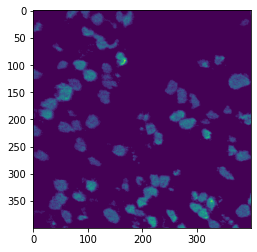

In [79]:
plt.imshow(input_data[3, :400, :400, 0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  


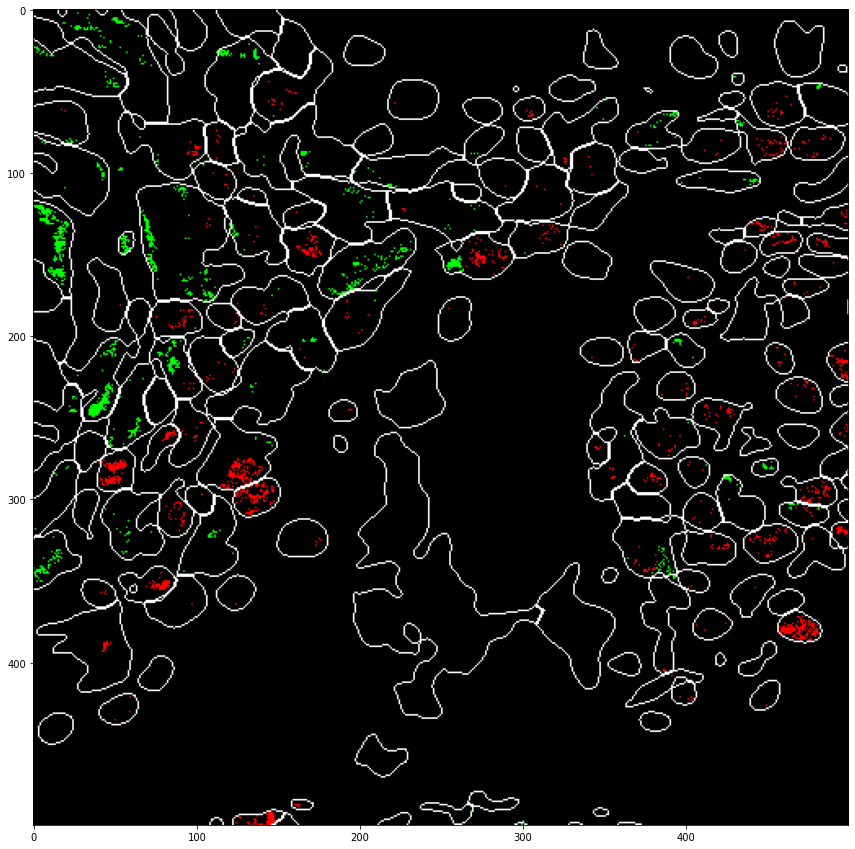

In [62]:
cmap = plt.get_cmap('viridis')
cmap.set_bad('black')
index = 1
#fig, axes = plt.subplots(2,3,figsize=(30,20))
fig, axes = plt.subplots(figsize=(15, 15))
axes.imshow(predicted_overlay[index, :500, :500, :])
# axes = axes.flatten()
# axes[0].imshow(RGB_data[index[0],...])
# axes[1].imshow(inner_distance[index[0],...,0], cmap='jet')
# axes[2].imshow(pixelwise[index[0],...,0], cmap='jet')
# axes[3].imshow(predicted_overlay[index[0], ...], cmap=cmap)
# # axes[4].imshow(true_overlay[index[0], ...], cmap=cmap)

# axes[0].set_title('Color_overlay', fontsize=24)
# axes[1].set_title('Inner distance', fontsize=24)
# axes[2].set_title('Pixelwise Border', fontsize=24)
# axes[3].set_title('Predicted Overlay', fontsize=24)
# # axes[4].set_title('True Overlay', fontsize=24)
# # axes[5].set_title('Ground Truth Mask', fontsize=24)

# for ax in axes.flatten():
#     ax.set_axis_off()

IndexError: index 17 is out of bounds for axis 0 with size 17

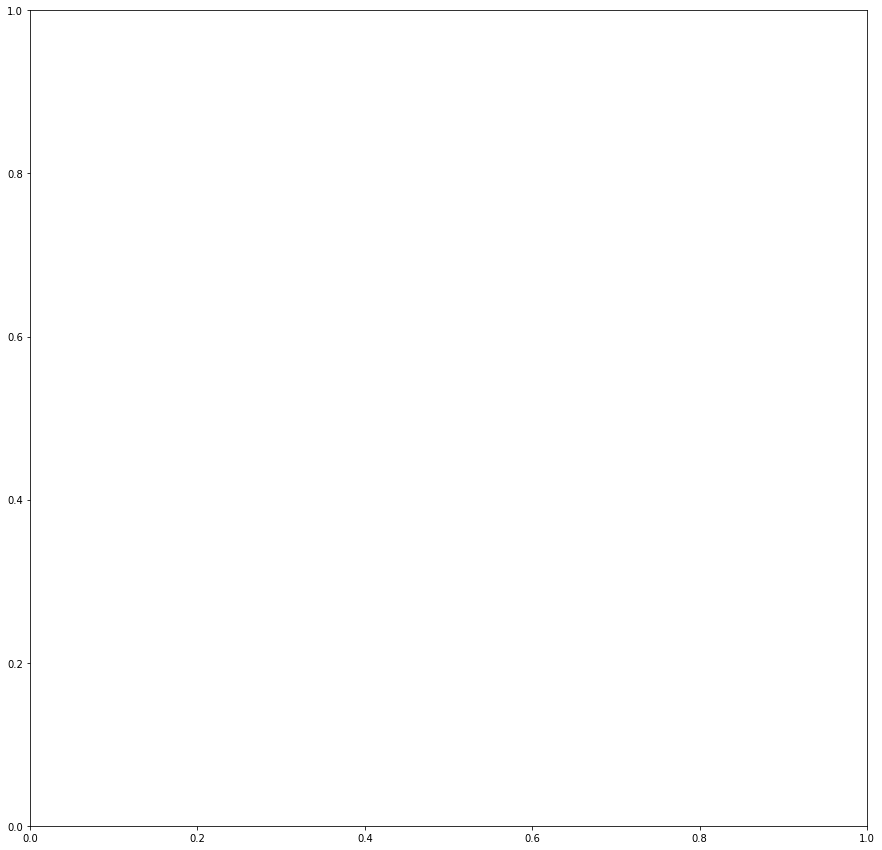

In [151]:
fig, axes = plt.subplots(figsize=(15,15))
axes.imshow(predicted_overlay[17, ...], cmap=cmap)
